# 🧠 Language Detection Using CNN

This notebook trains a Convolutional Neural Network (CNN) to recognize languages from text input.

## Project Overview

**Objective:** Design and develop a CNN-based model capable of accurately identifying the language of a given text while remaining lightweight, adaptable, and easy to implement.

**Key Features:**
- Character-level CNN for language classification
- Supports multiple languages (English, French, Spanish, Khmer, Japanese, etc.)
- Efficient extraction of language-specific character and word patterns
- Easy-to-use preprocessing and evaluation pipeline

---

## Table of Contents
1. [Setup & Installation](#1-setup--installation)
2. [Import Libraries](#2-import-libraries)
3. [Data Preprocessing](#3-data-preprocessing)
4. [Dataset & DataLoader](#4-dataset--dataloader)
5. [Model Architecture](#5-model-architecture)
6. [Training](#6-training)
7. [Evaluation & Visualization](#7-evaluation--visualization)
8. [Inference - Predict Language](#8-inference---predict-language)
9. [Usage Instructions](#9-usage-instructions)

## 1. Setup & Installation

First, install the required dependencies. Run this cell only once when setting up the environment.

In [ ]:
# Install required packages (uncomment and run if needed)
# !pip install torch torchvision numpy pandas scikit-learn matplotlib seaborn tqdm pillow

# Optional: Install OCR packages for text extraction from images
# !pip install pytesseract opencv-python easyocr

## 2. Import Libraries

Import all necessary libraries for data processing, model building, and visualization.

In [44]:
import os
import json
import numpy as np
import pandas as pd
import unicodedata
from glob import glob
from collections import Counter
from tqdm import tqdm
import random

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Using device: {device}")
print(f"📦 PyTorch version: {torch.__version__}")

🔧 Using device: cuda
📦 PyTorch version: 2.9.1+cu126


In [45]:
# Set up paths (adjust these if running from different location)
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Project root
DATA_RAW = os.path.join(BASE_DIR, "data", "raw")
DATA_PROC = os.path.join(BASE_DIR, "data", "processed")
MODEL_DIR = os.path.join(BASE_DIR, "models")

# Create directories if they don't exist
os.makedirs(DATA_RAW, exist_ok=True)
os.makedirs(DATA_PROC, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"📁 Base directory: {BASE_DIR}")
print(f"📁 Raw data: {DATA_RAW}")
print(f"📁 Processed data: {DATA_PROC}")
print(f"📁 Models: {MODEL_DIR}")

📁 Base directory: c:\Users\USER\Desktop\KIT Y2\Semester 2\Deep Learning with Python\Projects\DL-Lang-Detect\language-detection-model
📁 Raw data: c:\Users\USER\Desktop\KIT Y2\Semester 2\Deep Learning with Python\Projects\DL-Lang-Detect\language-detection-model\data\raw
📁 Processed data: c:\Users\USER\Desktop\KIT Y2\Semester 2\Deep Learning with Python\Projects\DL-Lang-Detect\language-detection-model\data\processed
📁 Models: c:\Users\USER\Desktop\KIT Y2\Semester 2\Deep Learning with Python\Projects\DL-Lang-Detect\language-detection-model\models


## 3. Data Preprocessing

### 3.1 Data Loading Functions

The preprocessing pipeline:
1. Looks for CSV files in `data/raw/` with columns (text, label) OR `.txt` files (one sample per line) named `<lang>.txt`
2. Builds character-level vocabulary
3. Encodes text → fixed-length integer sequences
4. Saves processed outputs to `data/processed/`

**Supported data formats:**
- **CSV files:** Must have columns `text` and `label`
- **TXT files:** Named after the language (e.g., `en.txt`, `fr.txt`) with one sample per line

In [46]:
# ============================================================
# DATA PREPROCESSING FUNCTIONS
# ============================================================

def unicode_normalize(s):
    """Normalize unicode characters to NFKC form."""
    return unicodedata.normalize("NFKC", str(s))

def load_raw_data(data_raw_path, validate=True, min_text_length=10):
    """
    Load raw data from CSV and TXT files with built-in validation.
    
    Args:
        data_raw_path: Path to raw data directory
        validate: Whether to validate and clean data
        min_text_length: Minimum text length to keep
    
    Returns:
        DataFrame with columns ['text', 'label']
    """
    rows = []
    
    # Load CSV files
    for csv_path in glob(os.path.join(data_raw_path, "*.csv")):
        try:
            df = pd.read_csv(csv_path, usecols=["text", "label"])
            rows.append(df)
            print(f"  ✅ Loaded CSV: {os.path.basename(csv_path)} ({len(df)} samples)")
        except Exception:
            # Fallback: assume two columns without headers
            df = pd.read_csv(csv_path, header=None, names=["text", "label"])
            rows.append(df)
            print(f"  ✅ Loaded CSV (no header): {os.path.basename(csv_path)} ({len(df)} samples)")
    
    # Load TXT files (each file = one language)
    for txt_path in glob(os.path.join(data_raw_path, "*.txt")):
        name = os.path.splitext(os.path.basename(txt_path))[0]
        with open(txt_path, "r", encoding="utf-8") as f:
            lines = [l.strip() for l in f if l.strip()]
        if lines:
            df = pd.DataFrame({"text": lines, "label": [name] * len(lines)})
            rows.append(df)
            print(f"  ✅ Loaded TXT: {os.path.basename(txt_path)} ({len(lines)} samples, label='{name}')")
    
    if not rows:
        return None
    
    df = pd.concat(rows, ignore_index=True)
    
    # Normalize text
    try:
        if LOWERCASE:
            df['text'] = df['text'].astype(str).map(lambda s: unicode_normalize(s).lower())
        else:
            df['text'] = df['text'].astype(str).map(unicode_normalize)
    except NameError:
        df['text'] = df['text'].astype(str).map(unicode_normalize)
    
    df['label'] = df['label'].astype(str).str.strip()
    
    # DATA VALIDATION (NEW!)
    if validate:
        print("\n🔍 Validating data quality...")
        initial = len(df)
        
        # Remove empty or very short texts
        df = df[df['text'].str.len() >= min_text_length]
        if len(df) < initial:
            print(f"   ⚠️  Removed {initial - len(df)} texts shorter than {min_text_length} chars")
        
        # Remove empty labels
        initial = len(df)
        df = df[df['label'].str.len() > 0]
        if len(df) < initial:
            print(f"   ⚠️  Removed {initial - len(df)} entries with empty labels")
        
        # Check for suspicious labels
        label_counts = df['label'].value_counts()
        suspicious = label_counts[label_counts < 10]
        if len(suspicious) > 0:
            print(f"   ⚠️  Warning: {len(suspicious)} labels have <10 samples: {suspicious.index.tolist()}")
        
        # Show text length statistics
        text_lengths = df['text'].str.len()
        print(f"\n📏 Text length stats:")
        print(f"   Min: {text_lengths.min()}, Max: {text_lengths.max()}, Avg: {text_lengths.mean():.1f}")
        
        df = df.reset_index(drop=True)
    
    return df

def generate_sample_dataset(out_path):
    """
    Generate a sample dataset for testing the pipeline.
    In production, replace this with your actual dataset.
    """
    samples = [
        # English samples
        ("hello world", "en"),
        ("this is a test", "en"),
        ("how are you today", "en"),
        ("machine learning is fascinating", "en"),
        ("deep neural networks", "en"),
        ("natural language processing", "en"),
        ("the quick brown fox jumps", "en"),
        ("artificial intelligence research", "en"),
        
        # French samples
        ("bonjour le monde", "fr"),
        ("je suis étudiant", "fr"),
        ("comment allez-vous", "fr"),
        ("apprentissage automatique", "fr"),
        ("traitement du langage naturel", "fr"),
        ("intelligence artificielle", "fr"),
        ("bonne journée à tous", "fr"),
        ("merci beaucoup", "fr"),
        
        # Spanish samples
        ("hola mundo", "es"),
        ("buenos días", "es"),
        ("cómo estás hoy", "es"),
        ("aprendizaje automático", "es"),
        ("procesamiento del lenguaje", "es"),
        ("inteligencia artificial", "es"),
        ("muchas gracias", "es"),
        ("hasta luego amigos", "es"),
        
        # Khmer samples
        ("សួស្តី​ពិភពលោក", "km"),
        ("ជំរាបសួរ", "km"),
        ("សូមអរគុណ", "km"),
        ("រៀនភាសា", "km"),
        ("កម្ពុជា", "km"),
        ("ភ្នំពេញ", "km"),
        
        # Japanese samples
        ("こんにちは世界", "jp"),
        ("おはようございます", "jp"),
        ("ありがとうございます", "jp"),
        ("機械学習", "jp"),
        ("自然言語処理", "jp"),
        ("人工知能", "jp"),
    ]
    
    df = pd.DataFrame(samples, columns=["text", "label"])
    df.to_csv(out_path, index=False, encoding="utf-8")
    print(f"✅ Sample dataset saved to: {out_path}")
    return df

def build_char_vocab(texts, min_freq=1, max_vocab=None):
    """
    Build character-level vocabulary from texts.
    
    Returns:
        idx2char: list of characters (index -> char)
        char2idx: dict mapping char -> index
    """
    cnt = Counter()
    for t in texts:
        cnt.update(list(t))
    
    items = [c for c, f in cnt.most_common() if f >= min_freq]
    if max_vocab:
        items = items[:max_vocab]
    
    # Reserve 0 for PAD, 1 for UNK
    idx2char = ["<pad>", "<unk>"] + items
    char2idx = {c: i for i, c in enumerate(idx2char)}
    
    return idx2char, char2idx

def encode_text(s, char2idx, max_len):
    """
    Encode text to fixed-length integer sequence.
    
    Args:
        s: input text
        char2idx: character to index mapping
        max_len: maximum sequence length
    
    Returns:
        List of integers (padded/truncated to max_len)
    """
    s = s[:max_len]
    ids = [char2idx.get(ch, 1) for ch in s]  # UNK -> 1
    if len(ids) < max_len:
        ids = ids + [0] * (max_len - len(ids))  # PAD -> 0
    return ids

print("✅ Preprocessing functions defined!")

✅ Preprocessing functions defined!


Dataset Cleaning Cell


In [47]:
# ============================================================
# DATASET CLEANING CELL - RUN THIS ONCE
# ============================================================
import re
def normalize_text_clean(text):
    """Normalize unicode and clean whitespace."""
    if pd.isna(text):
        return ""
    text = str(text)
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r'\s+', ' ', text)  # Remove excessive whitespace
    return text.strip()
def is_valid_text_clean(text, min_length=10, max_length=1000):
    """Check if text is valid for language detection."""
    if not text or len(text) < min_length or len(text) > max_length:
        return False
    
    # Must have at least 3 alphabetic characters
    alpha_count = sum(1 for c in text if c.isalpha())
    if alpha_count < 3:
        return False
    
    # Check for excessive special characters (>50%)
    special_count = sum(1 for c in text if not c.isalnum() and not c.isspace())
    if special_count / len(text) > 0.5:
        return False
    
    return True
def clean_malformed_csv(input_path, output_path, min_length=10, max_length=1000):
    """Clean dataset by fixing malformed CSV entries."""
    print(f"📂 Reading: {input_path}")
    
    # Manual parsing for malformed CSV
    rows = []
    with open(input_path, 'r', encoding='utf-8', errors='replace') as f:
        lines = f.readlines()
    
    # Skip header
    start_idx = 1 if lines and ('text' in lines[0].lower() or 'language' in lines[0].lower()) else 0
    
    current_text = ""
    current_label = None
    
    for line in lines[start_idx:]:
        line = line.strip()
        if not line:
            continue
        
        # Check if line contains comma (text,label pair)
        if ',' in line:
            parts = line.rsplit(',', 1)  # Split from right
            text_part = parts[0].strip()
            label_part = parts[1].strip() if len(parts) > 1 else ""
            
            # Save accumulated text
            if current_text and current_label:
                rows.append({'text': current_text, 'label': current_label})
            
            current_text = text_part
            current_label = label_part
        else:
            # Continuation of previous text
            current_text = (current_text + " " + line) if current_text else line
    
    # Add last entry
    if current_text and current_label:
        rows.append({'text': current_text, 'label': current_label})
    
    df = pd.DataFrame(rows)
    initial = len(df)
    print(f"✅ Parsed: {initial:,} entries")
    
    # Clean and validate
    print("\n🔧 Cleaning...")
    df['text'] = df['text'].apply(normalize_text_clean)
    df['label'] = df['label'].apply(lambda x: str(x).strip())
    
    # Remove invalid entries
    before = len(df)
    df = df[df['text'].str.len() > 0]
    df = df[df['label'].str.len() > 0]
    print(f"   - Removed {before - len(df)} empty entries")
    
    before = len(df)
    df['valid'] = df['text'].apply(lambda x: is_valid_text_clean(x, min_length, max_length))
    df = df[df['valid']].drop('valid', axis=1)
    print(f"   - Removed {before - len(df)} invalid texts")
    
    before = len(df)
    df = df.drop_duplicates(subset=['text'], keep='first')
    print(f"   - Removed {before - len(df)} duplicates")
    
    # Remove rare labels
    label_counts = df['label'].value_counts()
    valid_labels = label_counts[label_counts >= 50].index
    before = len(df)
    df = df[df['label'].isin(valid_labels)]
    print(f"   - Removed {before - len(df)} samples with rare labels (<50)")
    
    df = df.reset_index(drop=True)
    
    # Save
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df.to_csv(output_path, index=False, encoding='utf-8')
    
    # Summary
    print("\n" + "="*60)
    print("📊 CLEANING SUMMARY")
    print("="*60)
    print(f"Initial:   {initial:,}")
    print(f"Final:     {len(df):,}")
    print(f"Removed:   {initial - len(df):,} ({(initial - len(df)) / initial * 100:.1f}%)")
    print(f"Languages: {len(df['label'].unique())}")
    print(f"\n📋 Top languages:")
    for lang, count in df['label'].value_counts().head(10).items():
        print(f"   {lang:15s}: {count:,}")
    print("="*60)
    
    return df
# RUN CLEANING
input_file = os.path.join(DATA_RAW, "dataset.csv")
output_file = os.path.join(DATA_RAW, "dataset_cleaned.csv")
print("🧹 CLEANING DATASET\n" + "="*60)
cleaned_df = clean_malformed_csv(input_file, output_file)
print(f"\n✅ Saved to: {output_file}")
print("\n💡 Now rename 'dataset.csv' to 'dataset_backup.csv' and 'dataset_cleaned.csv' to 'dataset.csv'")
print("   Then re-run Section 3.2 to reload the cleaned data!")

🧹 CLEANING DATASET
📂 Reading: c:\Users\USER\Desktop\KIT Y2\Semester 2\Deep Learning with Python\Projects\DL-Lang-Detect\language-detection-model\data\raw\dataset.csv
✅ Parsed: 21,999 entries

🔧 Cleaning...
   - Removed 0 empty entries
   - Removed 759 invalid texts
   - Removed 141 duplicates
   - Removed 0 samples with rare labels (<50)

📊 CLEANING SUMMARY
Initial:   21,999
Final:     21,099
Removed:   900 (4.1%)
Languages: 22

📋 Top languages:
   Japanese       : 999
   Chinese        : 998
   Korean         : 998
   Estonian       : 982
   Swedish        : 978
   Romanian       : 978
   Thai           : 976
   Dutch          : 975
   Turkish        : 964
   Tamil          : 961

✅ Saved to: c:\Users\USER\Desktop\KIT Y2\Semester 2\Deep Learning with Python\Projects\DL-Lang-Detect\language-detection-model\data\raw\dataset_cleaned.csv

💡 Now rename 'dataset.csv' to 'dataset_backup.csv' and 'dataset_cleaned.csv' to 'dataset.csv'
   Then re-run Section 3.2 to reload the cleaned data!


### 3.2 Load and Preprocess Data

Run this cell to load your data and create the processed files. If no data is found, a sample dataset will be generated.

In [48]:
# ============================================================
# PREPROCESSING CONFIGURATION
# ============================================================

# Hyperparameters for preprocessing
MAX_LEN = 256      # Maximum sequence length (increased for better context)
MIN_FREQ = 1       # Minimum character frequency to include in vocabulary
MAX_VOCAB = None   # Maximum vocabulary size (None = no limit)
LOWERCASE = True   # Normalize to lowercase (safe for most languages; no effect on scripts without case)

# ============================================================
# LOAD AND PREPROCESS DATA
# ============================================================

print("📊 Loading raw data...")
df = load_raw_data(DATA_RAW)

# If no data found, generate sample dataset
if df is None or df.empty:
    print("⚠️ No raw data found. Generating sample dataset for testing...")
    sample_path = os.path.join(DATA_RAW, "sample_data.csv")
    df = generate_sample_dataset(sample_path)
    df = load_raw_data(DATA_RAW)

print(f"\n📈 Total samples loaded: {len(df)}")

# Basic cleaning: drop empty texts AND invalid labels
df = df[df['text'].str.strip().astype(bool)].reset_index(drop=True)
df = df[df['label'] != 'language'].reset_index(drop=True)  # Remove header row
print(f"📈 After cleaning: {len(df)} samples")

# Show sample distribution
print("\n📊 Label distribution:")
print(df['label'].value_counts())

📊 Loading raw data...
  ✅ Loaded CSV: dataset.csv (21099 samples)
  ✅ Loaded CSV (no header): dataset_backup.csv (22001 samples)

🔍 Validating data quality...
   ⚠️  Removed 2 texts shorter than 10 chars

📏 Text length stats:
   Min: 13, Max: 1408, Avg: 341.7

📈 Total samples loaded: 43098
📈 After cleaning: 43097 samples

📊 Label distribution:
label
Japanese      1998
Chinese       1998
Korean        1998
Estonian      1982
Swedish       1978
Romanian      1978
Thai          1976
Dutch         1974
Turkish       1964
Tamil         1961
Spanish       1961
English       1960
Portugese     1958
Urdu          1954
Russian       1951
Indonesian    1950
French        1949
Arabic        1948
Persian       1937
Latin         1931
Hindi         1925
Pushto        1866
Name: count, dtype: int64


In [49]:
# ============================================================
# BUILD VOCABULARY AND ENCODE DATA
# ============================================================

# Build label mapping
labels = sorted(df['label'].unique().tolist())
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}

print("🏷️ Label mapping:")
for label, idx in label2id.items():
    print(f"   {label} -> {idx}")

# Encode labels
y = df['label'].map(label2id).astype(np.int32).values

# Compute class weights (useful if classes are imbalanced)
try:
    class_weights = compute_class_weight('balanced', classes=np.arange(len(labels)), y=y)
    class_weights = class_weights.astype(np.float32)
    print(f"\n⚖️ Computed class weights for loss: {class_weights}")
except Exception as e:
    print(f"Could not compute class weights: {e}")
    class_weights = np.ones(len(labels), dtype=np.float32)

# Build character vocabulary
texts = df['text'].astype(str).tolist()
idx2char, char2idx = build_char_vocab(texts, min_freq=MIN_FREQ, max_vocab=MAX_VOCAB)

print(f"\n📝 Vocabulary size: {len(idx2char)} (including PAD/UNK)")
print(f"   Sample chars: {idx2char[:20]}...")

# Encode all texts
print("\n⏳ Encoding texts...")
X = np.array([encode_text(t, char2idx, MAX_LEN) for t in tqdm(texts)], dtype=np.int32)

print(f"\n✅ Encoded data shape: X={X.shape}, y={y.shape}")

🏷️ Label mapping:
   Arabic -> 0
   Chinese -> 1
   Dutch -> 2
   English -> 3
   Estonian -> 4
   French -> 5
   Hindi -> 6
   Indonesian -> 7
   Japanese -> 8
   Korean -> 9
   Latin -> 10
   Persian -> 11
   Portugese -> 12
   Pushto -> 13
   Romanian -> 14
   Russian -> 15
   Spanish -> 16
   Swedish -> 17
   Tamil -> 18
   Thai -> 19
   Turkish -> 20
   Urdu -> 21

⚖️ Computed class weights for loss: [1.0056235  0.9804577  0.9923782  0.9994666  0.9883726  1.0051075
 1.0176387  1.0045921  0.9804577  0.9804577  1.0144768  1.0113343
 1.0004876  1.0498148  0.99037135 1.0040772  0.9989569  0.99037135
 0.9989569  0.9913738  0.99743104 1.0025356 ]

📝 Vocabulary size: 7047 (including PAD/UNK)
   Sample chars: ['<pad>', '<unk>', ' ', 'e', 'a', 'i', 'n', 'r', 't', 's', 'o', 'l', 'd', 'ا', 'u', 'm', 'c', 'و', 'p', 'ر']...

⏳ Encoding texts...


100%|██████████| 43097/43097 [00:01<00:00, 30228.43it/s]


✅ Encoded data shape: X=(43097, 256), y=(43097,)


Inspect Data Quality

In [52]:
# ============================================================
# DATA QUALITY INSPECTION
# ============================================================
print("🔍 DATA QUALITY REPORT")
print("="*60)
# Show random samples per language
print("\n📝 Random samples per language (first 5 languages):\n")
for lang in df['label'].unique()[:5]:
    samples = df[df['label'] == lang]['text'].sample(min(3, len(df[df['label'] == lang])))
    print(f"\n{lang}:")
    for i, text in enumerate(samples, 1):
        preview = text[:80] + "..." if len(text) > 80 else text
        print(f"  {i}. {preview}")
# Character distribution analysis
print("\n\n📊 Character distribution analysis:")
for lang in df['label'].unique()[:5]:
    lang_texts = df[df['label'] == lang]['text']
    all_chars = ''.join(lang_texts)
    unique_chars = len(set(all_chars))
    print(f"  {lang:15s}: {unique_chars:4d} unique characters")
print("\n" + "="*60)
print("✅ If samples look good, proceed with training!")
print("⚠️  If you see gibberish or wrong labels, re-run cleaning!")

🔍 DATA QUALITY REPORT

📝 Random samples per language (first 5 languages):


Estonian:
  1. hariliku sibula seltsilistaimena kellega sibulad koos hästi kasvavad soovitataks...
  2. ta lõpetas aastal  tartus a grassi saksa tütarlastegümnaasiumi õppis aastatel – ...
  3. laulu video on filmitud ghanas tokyos londonis ja new yorgis videos on edisoodil...

Swedish:
  1. månen är den enda himlakroppen som människor har färdats till och landat på det ...
  2. ci kibah är ett vattendrag i indonesien det ligger i provinsen jawa barat i den ...
  3. juda stam var den ledande stammen i juda rike och befolkade den större delen av ...

Thai:
  1. สามพจน์แรกมีสัมประสิทธิ์เป็น − และ ตามลําดับ พจน์ที่สามไม่มีตัวแปร ดังนั้นพจน์ดั...
  2. เดอะแบงค์จ็อบ อังกฤษ the bank job วีซีดีจําหน่ายในไทยใช้ชื่อว่า เปิดตํานาน "ปล้น...
  3. โป๊ยเซียน 八仙 มาจากภาษาจีน แปลว่าเทพยดาทั้ง  องค์ ได้แก่ เซียนทิก๋วยลี้ เซียนฮั่น...

Tamil:
  1. சில நிகழ்வுகளில் பிரதிநிதித்துவ கோட்பாட்டின் பயன்பாட்டு வடிவங்கள் பலவீனமானதாக இர...

In [53]:
# ============================================================
# SAVE PROCESSED DATA
# ============================================================

# Save numpy arrays
np.save(os.path.join(DATA_PROC, "X.npy"), X)
np.save(os.path.join(DATA_PROC, "y.npy"), y)

# Save vocabulary and label mapping
with open(os.path.join(DATA_PROC, "label_map.json"), "w", encoding="utf-8") as f:
    json.dump(label2id, f, ensure_ascii=False, indent=2)

with open(os.path.join(DATA_PROC, "vocab.json"), "w", encoding="utf-8") as f:
    json.dump(idx2char, f, ensure_ascii=False, indent=2)

print(f"✅ Saved processed data to: {DATA_PROC}")
print(f"   - X.npy: {X.shape}")
print(f"   - y.npy: {y.shape}")
print(f"   - vocab.json: {len(idx2char)} characters")
print(f"   - label_map.json: {len(label2id)} labels")

✅ Saved processed data to: c:\Users\USER\Desktop\KIT Y2\Semester 2\Deep Learning with Python\Projects\DL-Lang-Detect\language-detection-model\data\processed
   - X.npy: (43097, 256)
   - y.npy: (43097,)
   - vocab.json: 7047 characters
   - label_map.json: 22 labels


## 4. Dataset & DataLoader

Create PyTorch Dataset and DataLoader for training, validation, and testing.

In [54]:
# ============================================================
# PYTORCH DATASET CLASS
# ============================================================

class LangDataset(Dataset):
    """
    PyTorch Dataset for language detection.
    
    Loads preprocessed data (X.npy, y.npy) and performs deterministic train/val/test split.
    """
    
    def __init__(self, split="train", test_frac=0.15, val_frac=0.15, load_path=None):
        """
        Args:
            split: 'train', 'val', or 'test'
            test_frac: fraction of data for testing
            val_frac: fraction of data for validation
            load_path: path to processed data directory
        """
        if load_path is None:
            load_path = DATA_PROC
            
        self.split = split
        # Load data
        xp = np.load(os.path.join(load_path, "X.npy"))
        yp = np.load(os.path.join(load_path, "y.npy"))
        
        # Deterministic shuffle
        rng = np.random.RandomState(42)
        perm = rng.permutation(len(xp))
        xp = xp[perm]
        yp = yp[perm]
        
        # Calculate split sizes
        n = len(xp)
        n_test = int(n * test_frac)
        n_val = int(n * val_frac)
        n_train = n - n_test - n_val
        
        # Split data
        train_X, train_y = xp[:n_train], yp[:n_train]
        val_X, val_y = xp[n_train:n_train+n_val], yp[n_train:n_train+n_val]
        test_X, test_y = xp[n_train+n_val:], yp[n_train+n_val:]
        
        if split == "train":
            self.X, self.y = train_X, train_y
        elif split == "val":
            self.X, self.y = val_X, val_y
        elif split == "test":
            self.X, self.y = test_X, test_y
        else:
            raise ValueError("split must be one of: train, val, test")
        
        # Load metadata
        vocab_path = os.path.join(load_path, "vocab.json")
        label_path = os.path.join(load_path, "label_map.json")
        
        self.idx2char = []
        self.label2id = {}
        
        if os.path.exists(vocab_path):
            with open(vocab_path, "r", encoding="utf-8") as f:
                self.idx2char = json.load(f)
        if os.path.exists(label_path):
            with open(label_path, "r", encoding="utf-8") as f:
                self.label2id = json.load(f)
    
    def __len__(self):
        return len(self.X)
    
    def augment_ids(self, ids, p=0.02):
        """Simple augmentation on id sequences: small prob to replace a char with UNK or swap adjacent tokens."""
        ids = ids.copy()
        L = len(ids)
        for i in range(L):
            if ids[i] == 0:
                continue
            if random.random() < p:
                # either replace with UNK
                if random.random() < 0.7:
                    ids[i] = 1
                else:
                    # try swap with next if possible
                    if i + 1 < L and ids[i+1] != 0:
                        ids[i], ids[i+1] = ids[i+1], ids[i]
        return ids
    
    def __getitem__(self, idx):
        ids = self.X[idx].copy()
        if self.split == "train":
            ids = self.augment_ids(ids, p=0.02)
        x = torch.tensor(ids, dtype=torch.long)
        y = torch.tensor(int(self.y[idx]), dtype=torch.long)
        return x, y

print("✅ LangDataset class defined!")

✅ LangDataset class defined!


In [55]:
# ============================================================
# CREATE DATASETS AND DATALOADERS
# ============================================================

# Hyperparameters
BATCH_SIZE = 64

# Create datasets
train_ds = LangDataset(split="train")
val_ds = LangDataset(split="val")
test_ds = LangDataset(split="test")

print(f"📊 Dataset sizes:")
print(f"   Training:   {len(train_ds)} samples")
print(f"   Validation: {len(val_ds)} samples")
print(f"   Testing:    {len(test_ds)} samples")

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Get vocab and label info
vocab_size = len(train_ds.idx2char)
num_classes = len(train_ds.label2id)

print(f"\n📝 Vocabulary size: {vocab_size}")
print(f"🏷️ Number of classes: {num_classes}")

📊 Dataset sizes:
   Training:   30169 samples
   Validation: 6464 samples
   Testing:    6464 samples

📝 Vocabulary size: 7047
🏷️ Number of classes: 22


## 5. Model Architecture

### Character-level CNN for Language Detection

The model uses:
1. **Embedding Layer:** Converts character indices to dense vectors
2. **Convolutional Layers:** Multiple kernels (3, 5, 7) to capture n-gram patterns
3. **Max Pooling:** Extract most important features
4. **Dropout:** Regularization to prevent overfitting
5. **Fully Connected Layer:** Final classification

```
Input (batch, seq_len)
    ↓
Embedding (batch, seq_len, embed_dim)
    ↓
Transpose (batch, embed_dim, seq_len)
    ↓
[Conv1D → ReLU → MaxPool] × 3 (different kernel sizes)
    ↓
Concatenate
    ↓
Dropout
    ↓
Fully Connected → Logits
```

In [56]:
# ============================================================
# CHARACTER-LEVEL CNN MODEL
# ============================================================

class CharCNN(nn.Module):
    """
    Character-level Convolutional Neural Network for Language Detection.
    
    Architecture:
    - Embedding layer for character representations
    - Multiple parallel Conv1D layers with different kernel sizes
    - Global max pooling + average pooling
    - BatchNorm on conv outputs
    - Dropout for regularization
    - Fully connected output layer
    """
    
    def __init__(self, vocab_size, embed_dim, num_classes, 
                 num_filters=128, kernel_sizes=(3, 5, 7), dropout=0.3):
        """
        Args:
            vocab_size: Size of character vocabulary (including PAD/UNK)
            embed_dim: Embedding dimension for characters
            num_classes: Number of language classes
            num_filters: Number of filters per convolution
            kernel_sizes: Tuple of kernel sizes for parallel convolutions
            dropout: Dropout probability
        """
        super().__init__()
        
        # Character embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # Parallel convolution layers with different kernel sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embed_dim,
                out_channels=num_filters,
                kernel_size=k
            )
            for k in kernel_sizes
        ])
        # BatchNorm layers for conv outputs
        self.bns = nn.ModuleList([nn.BatchNorm1d(num_filters) for _ in kernel_sizes])
        
        # Regularization
        self.dropout = nn.Dropout(dropout)
        
        # Output layer: we concatenate max+avg pooled features
        self.fc = nn.Linear(num_filters * len(kernel_sizes) * 2, num_classes)
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch, seq_len)
        
        Returns:
            Logits tensor of shape (batch, num_classes)
        """
        # Embedding: (batch, seq_len) -> (batch, seq_len, embed_dim)
        emb = self.embedding(x)
        
        # Transpose for Conv1d: (batch, embed_dim, seq_len)
        emb = emb.transpose(1, 2)
        
        # Apply each convolution and pool
        conv_outs = []
        for i, conv in enumerate(self.convs):
            c = conv(emb)  # (batch, num_filters, L_out)
            c = self.bns[i](c)
            c = F.relu(c)
            maxp = F.max_pool1d(c, kernel_size=c.size(2)).squeeze(2)  # (batch, num_filters)
            avgp = F.avg_pool1d(c, kernel_size=c.size(2)).squeeze(2)  # (batch, num_filters)
            conv_outs.append(maxp)
            conv_outs.append(avgp)
        
        # Concatenate all conv outputs
        cat = torch.cat(conv_outs, dim=1)  # (batch, num_filters * len(kernel_sizes) * 2)
        
        # Dropout
        cat = self.dropout(cat)
        
        # Final classification
        logits = self.fc(cat)
        
        return logits

print("✅ CharCNN model class defined!")

✅ CharCNN model class defined!


In [58]:
# ============================================================
# MODEL CONFIGURATION & INITIALIZATION
# ============================================================

# Model hyperparameters
EMBED_DIM = 128       # Character embedding dimension (increased)
NUM_FILTERS = 256     # Number of convolution filters (increased)
KERNEL_SIZES = (3, 5, 7, 9)  # Different n-gram sizes (added 9)
DROPOUT = 0.3         # Dropout probability
LEARNING_RATE = 1e-3  # Learning rate
WEIGHT_DECAY = 1e-5   # Weight decay for optimizer
NUM_EPOCHS = 20       # Number of training epochs (22K dataset: 15-20 optimal)

# Create model
model = CharCNN(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    num_classes=num_classes,
    num_filters=NUM_FILTERS,
    kernel_sizes=KERNEL_SIZES,
    dropout=DROPOUT
)

# Move to device
model = model.to(device)

# Print model summary
print("🧠 Model Architecture:")
print("=" * 50)
print(model)
print("=" * 50)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")

🧠 Model Architecture:
CharCNN(
  (embedding): Embedding(7047, 128, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
    (1): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
    (2): Conv1d(128, 256, kernel_size=(7,), stride=(1,))
    (3): Conv1d(128, 256, kernel_size=(9,), stride=(1,))
  )
  (bns): ModuleList(
    (0-3): 4 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=2048, out_features=22, bias=True)
)

📊 Total parameters: 1,736,598
📊 Trainable parameters: 1,736,598


## 6. Training

Train the CNN model with validation monitoring and early saving of the best model.

In [59]:
# ============================================================
# EVALUATION FUNCTION
# ============================================================

def evaluate_model(model, loader, device):
    """
    Evaluate model on a data loader.
    
    Returns:
        accuracy, f1_score, true_labels, predictions
    """
    model.eval()
    preds = []
    gold = []
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            p = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(p.tolist())
            gold.extend(y.numpy().tolist())
    
    acc = accuracy_score(gold, preds)
    f1 = f1_score(gold, preds, average="macro")
    
    return acc, f1, gold, preds

print("✅ Evaluation function defined!")

✅ Evaluation function defined!


In [ ]:
# ============================================================
# TRAINING LOOP
# ============================================================

# Loss function and optimizer
# Use class weights if available
try:
    cw = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=cw)
    print(f"Using class-weighted loss: {class_weights}")
except Exception:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# Scheduler and early stopping
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
early_stop_patience = 4
epochs_no_improve = 0

# Training history
history = {
    "train_loss": [],
    "val_acc": [],
    "val_f1": []
}

best_val_acc = 0.0

print("🚀 Starting training...")
print("=" * 60)

for epoch in range(1, NUM_EPOCHS + 1):
    # Training phase
    model.train()
    total_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}")
    for x, y in pbar:
        x = x.to(device)
        y = y.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix(loss=total_loss / (pbar.n + 1))
    
    avg_loss = total_loss / len(train_loader)
    
    # Validation phase
    val_acc, val_f1, _, _ = evaluate_model(model, val_loader, device)
    
    # Log metrics
    history["train_loss"].append(avg_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)
    
    print(f"[Epoch {epoch}] Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    # Scheduler step (on validation accuracy)
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"  Learning rate: {current_lr:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        checkpoint = {
            "model_state": model.state_dict(),
            "vocab": idx2char,
            "label_map": label2id,
            "args": {
                "embed_dim": EMBED_DIM,
                "num_filters": NUM_FILTERS,
                "kernels": ",".join(map(str, KERNEL_SIZES)),
                "dropout": DROPOUT,
                "lowercase": bool(LOWERCASE),
                "max_len": MAX_LEN
            }
        }
        torch.save(checkpoint, os.path.join(MODEL_DIR, "best_model.pt"))
        print(f"  ✅ Saved best model (val_acc={val_acc:.4f})")
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epoch(s)")

    # Early stopping
    if epochs_no_improve >= early_stop_patience:
        print(f"⏸️ Early stopping triggered after {epochs_no_improve} epochs with no improvement")
        break

print("=" * 60)
print(f"🎉 Training complete! Best validation accuracy: {best_val_acc:.4f}")

Using class-weighted loss: [1.0056235  0.9804577  0.9923782  0.9994666  0.9883726  1.0051075
 1.0176387  1.0045921  0.9804577  0.9804577  1.0144768  1.0113343
 1.0004876  1.0498148  0.99037135 1.0040772  0.9989569  0.99037135
 0.9989569  0.9913738  0.99743104 1.0025356 ]
🚀 Starting training...


Epoch 1/20: 100%|██████████| 472/472 [00:23<00:00, 20.27it/s, loss=0.296]


[Epoch 1] Loss: 0.2958 | Val Acc: 0.9808 | Val F1: 0.9810
  Learning rate: 0.001000
  ✅ Saved best model (val_acc=0.9808)


Epoch 2/20: 100%|██████████| 472/472 [00:21<00:00, 21.57it/s, loss=0.105] 


[Epoch 2] Loss: 0.1048 | Val Acc: 0.9851 | Val F1: 0.9855
  Learning rate: 0.001000
  ✅ Saved best model (val_acc=0.9851)


Epoch 3/20: 100%|██████████| 472/472 [00:20<00:00, 23.27it/s, loss=0.0805]


[Epoch 3] Loss: 0.0805 | Val Acc: 0.9841 | Val F1: 0.9844
  Learning rate: 0.001000
  No improvement for 1 epoch(s)


Epoch 4/20: 100%|██████████| 472/472 [00:20<00:00, 23.22it/s, loss=0.0641]


[Epoch 4] Loss: 0.0641 | Val Acc: 0.9858 | Val F1: 0.9862
  Learning rate: 0.001000
  ✅ Saved best model (val_acc=0.9858)


Epoch 5/20: 100%|██████████| 472/472 [00:20<00:00, 23.07it/s, loss=0.0494]


[Epoch 5] Loss: 0.0494 | Val Acc: 0.9884 | Val F1: 0.9884
  Learning rate: 0.001000
  ✅ Saved best model (val_acc=0.9884)


Epoch 6/20: 100%|██████████| 472/472 [00:19<00:00, 24.21it/s, loss=0.0397]


[Epoch 6] Loss: 0.0397 | Val Acc: 0.9896 | Val F1: 0.9898
  Learning rate: 0.001000
  ✅ Saved best model (val_acc=0.9896)


Epoch 7/20: 100%|██████████| 472/472 [00:19<00:00, 24.57it/s, loss=0.0373]


[Epoch 7] Loss: 0.0373 | Val Acc: 0.9913 | Val F1: 0.9915
  Learning rate: 0.001000
  ✅ Saved best model (val_acc=0.9913)


Epoch 8/20: 100%|██████████| 472/472 [00:19<00:00, 24.74it/s, loss=0.0293]


[Epoch 8] Loss: 0.0293 | Val Acc: 0.9899 | Val F1: 0.9901
  Learning rate: 0.001000
  No improvement for 1 epoch(s)


Epoch 9/20: 100%|██████████| 472/472 [00:19<00:00, 24.76it/s, loss=0.0253]


[Epoch 9] Loss: 0.0253 | Val Acc: 0.9924 | Val F1: 0.9925
  Learning rate: 0.001000
  ✅ Saved best model (val_acc=0.9924)


Epoch 10/20: 100%|██████████| 472/472 [00:19<00:00, 24.80it/s, loss=0.0204]


[Epoch 10] Loss: 0.0204 | Val Acc: 0.9930 | Val F1: 0.9932
  Learning rate: 0.001000
  ✅ Saved best model (val_acc=0.9930)


Epoch 11/20: 100%|██████████| 472/472 [00:19<00:00, 24.45it/s, loss=0.0204]


[Epoch 11] Loss: 0.0204 | Val Acc: 0.9941 | Val F1: 0.9942
  Learning rate: 0.001000
  ✅ Saved best model (val_acc=0.9941)


Epoch 12/20: 100%|██████████| 472/472 [00:19<00:00, 24.67it/s, loss=0.0163]


[Epoch 12] Loss: 0.0163 | Val Acc: 0.9935 | Val F1: 0.9935
  Learning rate: 0.001000
  No improvement for 1 epoch(s)


Epoch 13/20: 100%|██████████| 472/472 [00:19<00:00, 24.82it/s, loss=0.0164]


[Epoch 13] Loss: 0.0164 | Val Acc: 0.9912 | Val F1: 0.9914
  Learning rate: 0.001000
  No improvement for 2 epoch(s)


Epoch 14/20: 100%|██████████| 472/472 [00:19<00:00, 24.48it/s, loss=0.0168]


[Epoch 14] Loss: 0.0168 | Val Acc: 0.9949 | Val F1: 0.9949
  Learning rate: 0.001000
  ✅ Saved best model (val_acc=0.9949)


Epoch 15/20: 100%|██████████| 472/472 [00:18<00:00, 25.37it/s, loss=0.0132]


[Epoch 15] Loss: 0.0132 | Val Acc: 0.9932 | Val F1: 0.9932
  Learning rate: 0.001000
  No improvement for 1 epoch(s)


Epoch 16/20: 100%|██████████| 472/472 [00:18<00:00, 25.41it/s, loss=0.0117] 


[Epoch 16] Loss: 0.0117 | Val Acc: 0.9935 | Val F1: 0.9936
  Learning rate: 0.001000
  No improvement for 2 epoch(s)


Epoch 17/20: 100%|██████████| 472/472 [00:19<00:00, 24.81it/s, loss=0.00912]


[Epoch 17] Loss: 0.0091 | Val Acc: 0.9947 | Val F1: 0.9948
  Learning rate: 0.000500
  No improvement for 3 epoch(s)


Epoch 18/20: 100%|██████████| 472/472 [00:18<00:00, 24.93it/s, loss=0.00408]


[Epoch 18] Loss: 0.0041 | Val Acc: 0.9957 | Val F1: 0.9957
  Learning rate: 0.000500
  ✅ Saved best model (val_acc=0.9957)


Epoch 19/20: 100%|██████████| 472/472 [00:19<00:00, 24.34it/s, loss=0.00324]


[Epoch 19] Loss: 0.0032 | Val Acc: 0.9960 | Val F1: 0.9960
  Learning rate: 0.000500
  ✅ Saved best model (val_acc=0.9960)


Epoch 20/20: 100%|██████████| 472/472 [00:20<00:00, 23.14it/s, loss=0.00305]


[Epoch 20] Loss: 0.0031 | Val Acc: 0.9960 | Val F1: 0.9960
  Learning rate: 0.000500
  No improvement for 1 epoch(s)
🎉 Training complete! Best validation accuracy: 0.9960


In [61]:
# ============================================================
# SAVE TRAINING HISTORY
# ============================================================

# Save history to JSON
with open(os.path.join(MODEL_DIR, "train_history.json"), "w") as f:
    json.dump(history, f, indent=2)

print(f"✅ Training history saved to: {os.path.join(MODEL_DIR, 'train_history.json')}")

✅ Training history saved to: c:\Users\USER\Desktop\KIT Y2\Semester 2\Deep Learning with Python\Projects\DL-Lang-Detect\language-detection-model\models\train_history.json


## 7. Evaluation & Visualization

Evaluate the trained model and visualize the results.

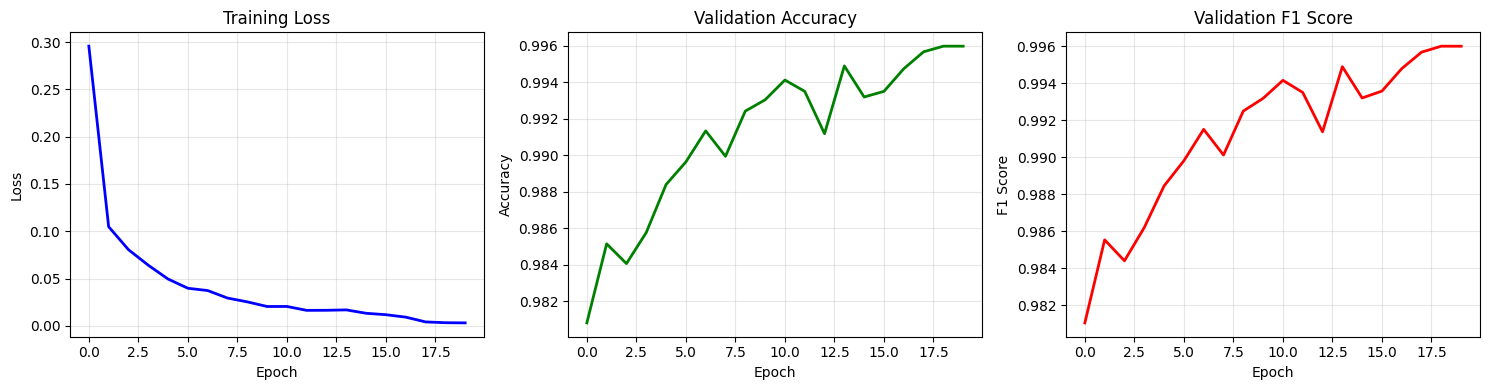

✅ Training curves saved to: c:\Users\USER\Desktop\KIT Y2\Semester 2\Deep Learning with Python\Projects\DL-Lang-Detect\language-detection-model\models\training_curves.png


In [62]:
# ============================================================
# PLOT TRAINING CURVES
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Training Loss
axes[0].plot(history["train_loss"], 'b-', linewidth=2)
axes[0].set_title("Training Loss", fontsize=12)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid(True, alpha=0.3)

# Validation Accuracy
axes[1].plot(history["val_acc"], 'g-', linewidth=2)
axes[1].set_title("Validation Accuracy", fontsize=12)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True, alpha=0.3)

# Validation F1 Score
axes[2].plot(history["val_f1"], 'r-', linewidth=2)
axes[2].set_title("Validation F1 Score", fontsize=12)
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("F1 Score")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, "training_curves.png"), dpi=150)
plt.show()

print(f"✅ Training curves saved to: {os.path.join(MODEL_DIR, 'training_curves.png')}")

In [63]:
# ============================================================
# LOAD BEST MODEL AND EVALUATE ON TEST SET
# ============================================================

# Load the best checkpoint
checkpoint_path = os.path.join(MODEL_DIR, "best_model.pt")
checkpoint = torch.load(checkpoint_path, map_location=device)

# Recreate model with saved configuration
saved_args = checkpoint.get("args", {})
model_best = CharCNN(
    vocab_size=len(checkpoint["vocab"]),
    embed_dim=saved_args.get("embed_dim", EMBED_DIM),
    num_classes=len(checkpoint["label_map"]),
    num_filters=saved_args.get("num_filters", NUM_FILTERS),
    kernel_sizes=tuple(map(int, saved_args.get("kernels", "3,5,7").split(","))),
    dropout=saved_args.get("dropout", DROPOUT)
)
model_best.load_state_dict(checkpoint["model_state"])
model_best = model_best.to(device)
model_best.eval()

# Evaluate on test set
test_acc, test_f1, gold, preds = evaluate_model(model_best, test_loader, device)

print("=" * 50)
print("📊 TEST SET RESULTS")
print("=" * 50)
print(f"   Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   F1 Score: {test_f1:.4f}")
print("=" * 50)

📊 TEST SET RESULTS
   Accuracy: 0.9947 (99.47%)
   F1 Score: 0.9949


In [64]:
# ============================================================
# DIAGNOSTICS: Check checkpoint vocab/label mapping and sample predictions
# ============================================================

print("🔍 Running diagnostics on checkpoint and processed artifacts...")

# Basic checkpoint info
cp = checkpoint
cp_vocab = cp.get("vocab", [])
cp_label_map = cp.get("label_map", {})
print(f"Checkpoint vocab size: {len(cp_vocab)}")
print(f"Checkpoint sample chars (first 40): {cp_vocab[:40]}")
print(f"Checkpoint label_map sample (first 20): {list(cp_label_map.items())[:20]}")

# id2label mapping
id2label_saved = {int(v): k for k, v in cp_label_map.items()}
print("\nid2label_saved (partial):")
for i in sorted(list(id2label_saved.keys())[:20]):
    print(f"  {i} -> {id2label_saved[i]}")

# Compare with processed files if available
vocab_path = os.path.join(DATA_PROC, "vocab.json")
label_map_path = os.path.join(DATA_PROC, "label_map.json")
if os.path.exists(vocab_path):
    with open(vocab_path, "r", encoding="utf-8") as f:
        proc_idx2char = json.load(f)
    print(f"\nProcessed vocab size: {len(proc_idx2char)}")
    print("First 20 chars equal between processed and checkpoint:", proc_idx2char[:20] == cp_vocab[:20])
else:
    print("\nNo processed vocab file found to compare.")

if os.path.exists(label_map_path):
    with open(label_map_path, "r", encoding="utf-8") as f:
        proc_label_map = json.load(f)
    print("Processed label_map keys equal to checkpoint:", set(proc_label_map.keys()) == set(cp_label_map.keys()))
else:
    print("No processed label_map file found to compare.")

# Encode a sample using checkpoint vocab
char2idx_cp = {c: i for i, c in enumerate(cp_vocab)}
sample = "Hello, how are you doing today?"
ids = [char2idx_cp.get(ch, 1) for ch in sample[:MAX_LEN]]
if len(ids) < MAX_LEN:
    ids = ids + [0] * (MAX_LEN - len(ids))
print(f"\nEncoded ids (first 60): {ids[:60]}")

# Run the saved model (model_best) on the sample and show top-k predictions
input_ids = torch.tensor([ids], dtype=torch.long).to(device)
with torch.no_grad():
    logits = model_best(input_ids)
    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

# Show top-k
top_k = 5
top_indices = probs.argsort()[::-1][:top_k]
print("\nTop predictions for sample:")
for idx in top_indices:
    lang = id2label_saved.get(int(idx), str(idx))
    print(f"  {lang}: {probs[idx]:.4f}")

print("\n✅ Diagnostics complete. If mappings differ, ensure predictor loads checkpoint 'vocab' and 'label_map' exactly.")

🔍 Running diagnostics on checkpoint and processed artifacts...
Checkpoint vocab size: 7047
Checkpoint sample chars (first 40): ['<pad>', '<unk>', ' ', 'e', 'a', 'i', 'n', 'r', 't', 's', 'o', 'l', 'd', 'ا', 'u', 'm', 'c', 'و', 'p', 'ر', 'ل', 'ن', 'g', 'h', 'ی', 'م', 'k', 'د', 'b', '்', 'ه', 'ت', 'v', 'ي', 'ب', 'س', 'f', 'о', 'ک', 'y']
Checkpoint label_map sample (first 20): [('Arabic', 0), ('Chinese', 1), ('Dutch', 2), ('English', 3), ('Estonian', 4), ('French', 5), ('Hindi', 6), ('Indonesian', 7), ('Japanese', 8), ('Korean', 9), ('Latin', 10), ('Persian', 11), ('Portugese', 12), ('Pushto', 13), ('Romanian', 14), ('Russian', 15), ('Spanish', 16), ('Swedish', 17), ('Tamil', 18), ('Thai', 19)]

id2label_saved (partial):
  0 -> Arabic
  1 -> Chinese
  2 -> Dutch
  3 -> English
  4 -> Estonian
  5 -> French
  6 -> Hindi
  7 -> Indonesian
  8 -> Japanese
  9 -> Korean
  10 -> Latin
  11 -> Persian
  12 -> Portugese
  13 -> Pushto
  14 -> Romanian
  15 -> Russian
  16 -> Spanish
  17 -> Swedi

In [65]:
# ============================================================
# CLASSIFICATION REPORT
# ============================================================

# Get label names - only for classes that appear in gold labels
id2label_saved = {int(v): k for k, v in checkpoint["label_map"].items()}
unique_labels = sorted(set(gold))  # Only include classes in test set
label_names = [id2label_saved[i] for i in unique_labels]

print("📋 CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(gold, preds, labels=unique_labels, target_names=label_names))

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Arabic       1.00      1.00      1.00       272
     Chinese       1.00      1.00      1.00       319
       Dutch       1.00      0.99      1.00       287
     English       0.95      0.99      0.97       318
    Estonian       1.00      0.98      0.99       297
      French       0.99      1.00      0.99       291
       Hindi       1.00      1.00      1.00       292
  Indonesian       1.00      1.00      1.00       268
    Japanese       1.00      0.99      1.00       320
      Korean       0.99      1.00      1.00       296
       Latin       0.98      0.97      0.98       313
     Persian       1.00      1.00      1.00       292
   Portugese       1.00      1.00      1.00       289
      Pushto       1.00      0.99      0.99       293
    Romanian       1.00      1.00      1.00       284
     Russian       0.99      1.00      1.00       301
     Spanish       1.00      0.99      0.99       299
   

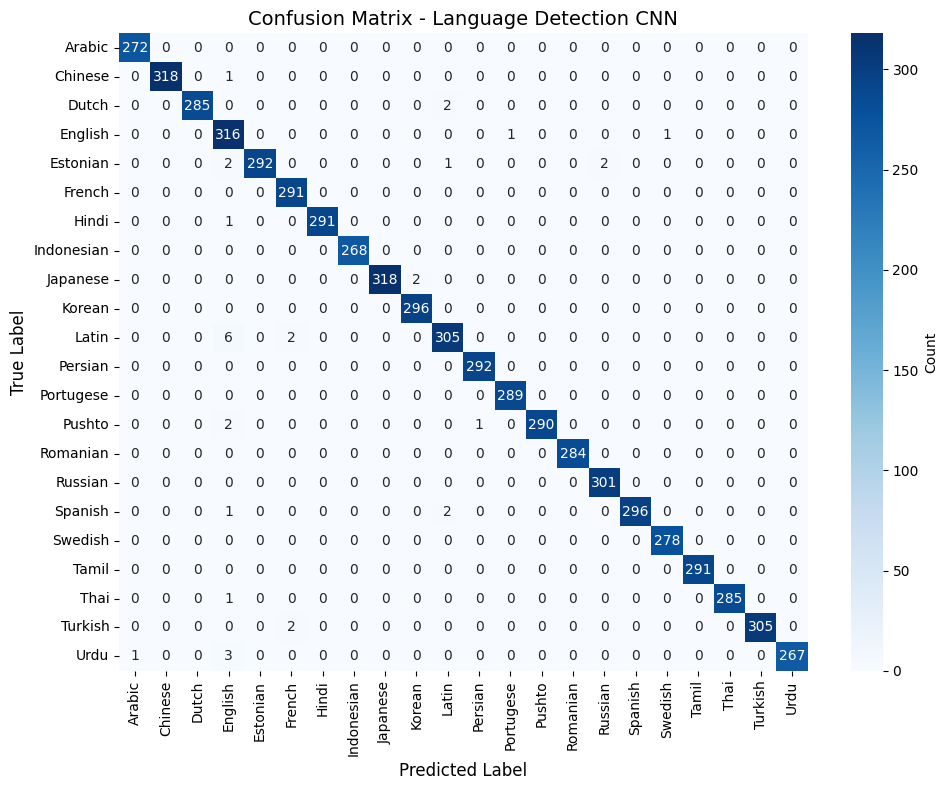

✅ Confusion matrix saved to: c:\Users\USER\Desktop\KIT Y2\Semester 2\Deep Learning with Python\Projects\DL-Lang-Detect\language-detection-model\models\confusion_matrix.png


In [66]:
# ============================================================
# CONFUSION MATRIX VISUALIZATION
# ============================================================

cm = confusion_matrix(gold, preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names,
    cbar_kws={'label': 'Count'}
)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix - Language Detection CNN", fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, "confusion_matrix.png"), dpi=150)
plt.show()

print(f"✅ Confusion matrix saved to: {os.path.join(MODEL_DIR, 'confusion_matrix.png')}")

Additional Diagnostics

In [ ]:
# ============================================================
# DIAGNOSTIC: Check if model was trained with cleaned data
# ============================================================
checkpoint_path = os.path.join(MODEL_DIR, "best_model.pt")
checkpoint = torch.load(checkpoint_path, map_location='cpu')
print("🔍 MODEL CHECKPOINT DIAGNOSTICS")
print("="*60)
# Check args
args = checkpoint.get("args", {})
print("\n📋 Model Configuration:")
print(f"   Embed dim:    {args.get('embed_dim', 'NOT SAVED')}")
print(f"   Num filters:  {args.get('num_filters', 'NOT SAVED')}")
print(f"   Kernels:      {args.get('kernels', 'NOT SAVED')}")
print(f"   Dropout:      {args.get('dropout', 'NOT SAVED')}")
print(f"   Lowercase:    {args.get('lowercase', 'NOT SAVED')}")
print(f"   Max length:   {args.get('max_len', 'NOT SAVED ⚠️')}")
# Check vocab size
vocab_size = len(checkpoint.get("vocab", []))
num_classes = len(checkpoint.get("label_map", {}))
print(f"\n📊 Model Stats:")
print(f"   Vocab size:   {vocab_size}")
print(f"   Num classes:  {num_classes}")
# Check label map
label_map = checkpoint.get("label_map", {})
print(f"\n🏷️  Languages in model:")
for lang in sorted(label_map.keys())[:10]:
    print(f"   - {lang}")
if len(label_map) > 10:
    print(f"   ... and {len(label_map) - 10} more")
# CRITICAL CHECK: Is "language" in the label map?
if "language" in label_map:
    print("\n❌ ERROR: Model still has 'language' label!")
    print("   This means the model was NOT retrained with cleaned data!")
    print("   You MUST retrain the model after cleaning the dataset!")
else:
    print("\n✅ Good: No 'language' label found (data was cleaned)")
print("="*60)

## 8. Inference - Predict Language

Use the trained model to predict the language of new text inputs.

In [ ]:
# ============================================================
# PREDICTION FUNCTION
# ============================================================

class LanguagePredictor:
    """
    A class for making language predictions with the trained CNN model.
    """
    
    def __init__(self, checkpoint_path, max_len=None):
        """
        Load model from checkpoint.
        
        Args:
            checkpoint_path: Path to the saved model checkpoint
            max_len: Maximum sequence length (defaults to checkpoint / global MAX_LEN)
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load checkpoint
        self.checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.idx2char = self.checkpoint["vocab"]
        self.label_map = self.checkpoint["label_map"]
        self.id2label = {int(v): k for k, v in self.label_map.items()}
        self.char2idx = {c: i for i, c in enumerate(self.idx2char)}
        
        # Determine max_len and lowercase flag
        args = self.checkpoint.get("args", {})
        # FIXED: Use checkpoint's max_len or default to 256
        self.max_len = max_len if max_len is not None else args.get("max_len", 256)
        self.lowercase = bool(args.get("lowercase", True))
        
        # Build model
        self.model = CharCNN(
            vocab_size=len(self.idx2char),
            embed_dim=args.get("embed_dim", 64),
            num_classes=len(self.label_map),
            num_filters=args.get("num_filters", 128),
            kernel_sizes=tuple(map(int, args.get("kernels", "3,5,7").split(","))),
            dropout=args.get("dropout", 0.3)
        )
        self.model.load_state_dict(self.checkpoint["model_state"])
        self.model = self.model.to(self.device)
        self.model.eval()
    
    def encode(self, text):
        """Encode text to integer sequence."""
        text = unicodedata.normalize("NFKC", str(text))
        if self.lowercase:
            text = text.lower()
        ids = [self.char2idx.get(ch, 1) for ch in text[:self.max_len]]
        if len(ids) < self.max_len:
            ids = ids + [0] * (self.max_len - len(ids))
        return ids
    
    def predict(self, text, top_k=3):
        """
        Predict language for input text.
        
        Args:
            text: Input text string
            top_k: Number of top predictions to return
        
        Returns:
            Tuple of (predicted_language, confidence, all_probabilities)
        """
        ids = torch.tensor([self.encode(text)], dtype=torch.long).to(self.device)
        
        with torch.no_grad():
            logits = self.model(ids)
            probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        
        # Get top-k predictions
        top_indices = probs.argsort()[::-1][:top_k]
        
        results = []
        for idx in top_indices:
            results.append({
                "language": self.id2label[idx],
                "confidence": float(probs[idx])
            })
        
        return results[0]["language"], results[0]["confidence"], results

print("✅ LanguagePredictor class defined!")

✅ LanguagePredictor class defined!


In [69]:
# ============================================================
# TEST PREDICTIONS
# ============================================================

# Initialize predictor
predictor = LanguagePredictor(os.path.join(MODEL_DIR, "best_model.pt"))

# Test samples
test_samples = [
    "Hello, how are you doing today?",
    "Bonjour, comment allez-vous?",
    "Hola, ¿cómo estás?",
    "សួស្តី​ពិភពលោក",
    "こんにちは、元気ですか？",
    "Machine learning is amazing",
    "L'intelligence artificielle",
]

print("🔮 LANGUAGE PREDICTIONS")
print("=" * 70)

for sample in test_samples:
    lang, conf, top_results = predictor.predict(sample, top_k=3)
    print(f"\n📝 Input: \"{sample}\"")
    print(f"   ➜ Predicted: {lang.upper()} (confidence: {conf:.2%})")
    # Format top 3 results
    top3_str = ", ".join([f"{r['language']}:{r['confidence']:.2%}" for r in top_results])
    print(f"   Top 3: {top3_str}")

🔮 LANGUAGE PREDICTIONS

📝 Input: "Hello, how are you doing today?"
   ➜ Predicted: CHINESE (confidence: 99.11%)
   Top 3: Chinese:99.11%, Portugese:0.54%, English:0.15%

📝 Input: "Bonjour, comment allez-vous?"
   ➜ Predicted: CHINESE (confidence: 99.98%)
   Top 3: Chinese:99.98%, Estonian:0.01%, French:0.00%

📝 Input: "Hola, ¿cómo estás?"
   ➜ Predicted: CHINESE (confidence: 99.53%)
   Top 3: Chinese:99.53%, Portugese:0.17%, Korean:0.17%

📝 Input: "សួស្តី​ពិភពលោក"
   ➜ Predicted: CHINESE (confidence: 70.74%)
   Top 3: Chinese:70.74%, Japanese:5.87%, Latin:3.33%

📝 Input: "こんにちは、元気ですか？"
   ➜ Predicted: JAPANESE (confidence: 100.00%)
   Top 3: Japanese:100.00%, Urdu:0.00%, Chinese:0.00%

📝 Input: "Machine learning is amazing"
   ➜ Predicted: LATIN (confidence: 48.32%)
   Top 3: Latin:48.32%, Indonesian:36.81%, Chinese:7.26%

📝 Input: "L'intelligence artificielle"
   ➜ Predicted: LATIN (confidence: 57.54%)
   Top 3: Latin:57.54%, Chinese:16.46%, Romanian:7.26%


In [79]:
# ============================================================
# INTERACTIVE PREDICTION
# ============================================================

def predict_language(text):
    """
    Simple function to predict language of input text.
    
    Usage:
        predict_language("Hello world")
    """
    lang, conf, results = predictor.predict(text)
    print(f"🌐 Language: {lang.upper()}")
    print(f"📊 Confidence: {conf:.2%}")
    print(f"📈 All probabilities:")
    for r in results:
        bar = "█" * int(r["confidence"] * 20)
        print(f"   {r['language']:>5}: {bar} {r['confidence']:.2%}")
    return lang, conf

# Try it yourself! Change the text below:
predict_language("I AM ENGLISH TEXT WITH A LITTLE OF SPANISH AND A LITTLE OF FRENCH")

🌐 Language: TAMIL
📊 Confidence: 41.86%
📈 All probabilities:
   Tamil: ████████ 41.86%
   Latin: ██████ 32.74%
   English: █ 9.05%


('Tamil', 0.41858911514282227)

## 9. Usage Instructions

### 📁 Project Structure
```
Deep Learning/
├── data/
│   ├── raw/           # Place your raw data files here
│   │   ├── *.csv      # CSV with columns: text, label
│   │   └── *.txt      # TXT files named <language>.txt
│   └── processed/     # Preprocessed data (auto-generated)
├── models/            # Saved models and artifacts
├── notebooks/
│   └── language_detection_cnn.ipynb
├── src/               # Source code modules
└── requirements.txt
```

---

### 🚀 Quick Start Guide

#### Step 1: Prepare Your Data
Place your data in `data/raw/` in one of these formats:

**Option A: CSV files**
```csv
text,label
Hello world,en
Bonjour le monde,fr
Hola mundo,es
```

**Option B: TXT files (one per language)**
- `en.txt` - One English sample per line
- `fr.txt` - One French sample per line
- etc.

#### Step 2: Run the Notebook
Execute cells in order:
1. **Cell 1-2**: Install dependencies & import libraries
2. **Cell 3-6**: Preprocess data (builds vocabulary, encodes text)
3. **Cell 7-8**: Create datasets and dataloaders
4. **Cell 9-10**: Define model architecture
5. **Cell 11-13**: Train the model
6. **Cell 14-17**: Evaluate and visualize results
7. **Cell 18-20**: Make predictions on new text

---

### ⚙️ Hyperparameters

| Parameter | Default | Description |
|-----------|---------|-------------|
| `MAX_LEN` | 128 | Maximum text sequence length |
| `BATCH_SIZE` | 32 | Training batch size |
| `EMBED_DIM` | 64 | Character embedding dimension |
| `NUM_FILTERS` | 128 | CNN filter count |
| `KERNEL_SIZES` | (3, 5, 7) | N-gram sizes to capture |
| `DROPOUT` | 0.3 | Dropout rate |
| `LEARNING_RATE` | 0.001 | Adam optimizer learning rate |
| `NUM_EPOCHS` | 10 | Training epochs |

---

### 📊 Adding More Languages

1. Add training data to `data/raw/`:
   - CSV: Add rows with new language label
   - TXT: Create `<lang_code>.txt` file

2. Re-run preprocessing cells (Section 3)

3. Re-train the model (Section 6)

---

### 💾 Using the Trained Model

```python
# Load the trained model
predictor = LanguagePredictor("models/best_model.pt")

# Predict language
language, confidence, all_results = predictor.predict("Your text here")
print(f"Language: {language}, Confidence: {confidence:.2%}")
```

---

### 🔧 Command Line Usage

You can also use the source files directly:

```bash
# Preprocess data
python src/preprocess.py --max-len 128

# Train model
python src/train.py --epochs 10 --batch-size 64

# Evaluate/predict
python src/evaluate.py --text "Hello world"
```

---

### 📚 Recommended Datasets

For production use, consider these multilingual datasets:
- **Tatoeba**: Sentence translations in 300+ languages
- **Wikipedia**: Text dumps for most languages
- **WMT**: Machine translation dataset
- **OPUS**: Parallel corpus collection

---

### 🎯 Tips for Better Performance

1. **More data**: Aim for 1000+ samples per language
2. **Balanced classes**: Equal samples per language
3. **Data augmentation**: Add noise, typos, case variations
4. **Longer training**: Increase epochs for larger datasets
5. **Adjust architecture**: Increase filters for more languages

---

## 🎉 Congratulations!

You have successfully trained a CNN-based language detection model. 

**What you've learned:**
- Character-level text preprocessing
- Building CNN architectures for text classification
- Training and evaluating deep learning models
- Making predictions with trained models

**Next Steps:**
- Add more languages to your dataset
- Experiment with different hyperparameters
- Try integrating with OCR for image-based language detection
- Deploy as a web API or mobile application

---

*Created for the Language Detection Deep Learning Project*